<a href="https://colab.research.google.com/github/cfrisby/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [1]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

print("hello world")

hello world


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

<class 'numpy.ndarray'>


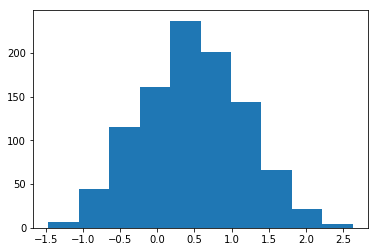

In [2]:
# TODO - your code here
# Use what we did live in lecture as an example
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Generate and plot a normal distribution using numpy

# help(np.random.normal)

sample = np.random.normal(0.5, 0.667, 1000)

print(type(sample))

plt.hist(sample)
plt.show()

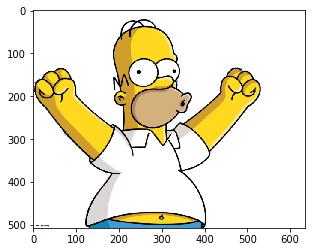

In [3]:
import matplotlib.image as mpimg
from PIL import Image
import requests
from io import BytesIO

# Plotting and manipulating images with matplotlib

response = requests.get('http://imagenpng.com/wp-content/uploads/2015/09/imagenes-png-635x508.png')
img = Image.open(BytesIO(response.content))

img = mpimg.imread(BytesIO(response.content))

# print(img)

imgplot = plt.imshow(img)

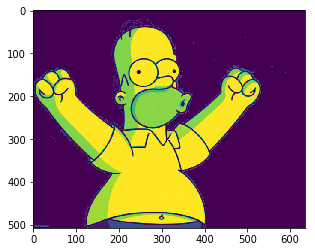

In [4]:
lum_img = img[:, : , 0]

plt.imshow(lum_img)

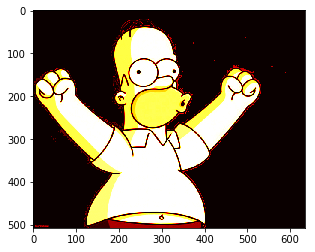

In [5]:
plt.imshow(lum_img, cmap="hot")

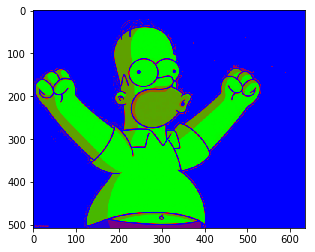

In [6]:
imgplot = plt.imshow(lum_img)
imgplot.set_cmap('brg')

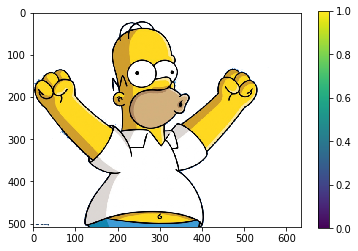

In [7]:
imgplot = plt.imshow(img)
plt.colorbar()

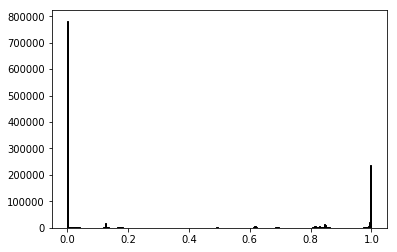

In [8]:
plt.hist(img.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k')
plt.show()

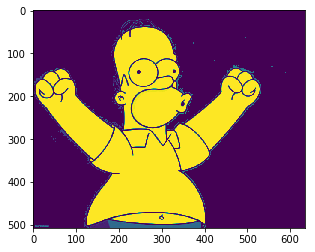

In [9]:
imgplot = plt.imshow(lum_img, clim=(0.0, 0.7))

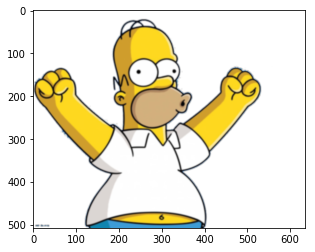

In [10]:
imgplot = plt.imshow(img, interpolation="bicubic")

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

    I tried a couple of different things - first, I learned how to create a normalized sample using numpy, and plotted the results using matplotlib. Then, I experimented with different ways to modify images using matplotlib. I had to use another library called Pillow to import the image from a url.

2.  What was the most challenging part of what you did?

    The most challenging part was sifting through the documentation for the various libraries that I used to try to understand how each function worked and what the different parameters are.

3.  What was the most interesting thing you learned?

    The most interesting thing I learned was that matplotlib can plot a PNG image (it makes sense, as it is just a raster of RGB values).

4.  What area would you like to explore with more time?

    I would like to dive deeper on some of the other libraries I used to see what else they are capable of - Pillow, and requests specifically.




In [19]:
grow_mart = {'name': 'Grow Mart', 'year_founded': 1973, 'annual_revenue': 265000, 'annual_expenses': 183000}
plant_depot = {'name': 'Plant Depot', 'year_founded': 1973, 'annual_revenue': 302000, 'annual_expenses': 240000}
trees_r_us = {'name': 'Trees\'R\'Us', 'year_founded': 1985, 'annual_revenue': 123000, 'annual_expenses': 130000}

stores = [grow_mart, plant_depot, trees_r_us]

for store in stores:
  store['is_profitable'] = (store['annual_revenue'] - store['annual_expenses']) > 0
  
print(stores)

[{'name': 'Grow Mart', 'year_founded': 1973, 'annual_revenue': 265000, 'annual_expenses': 183000, 'is_profitable': True}, {'name': 'Plant Depot', 'year_founded': 1973, 'annual_revenue': 302000, 'annual_expenses': 240000, 'is_profitable': True}, {'name': "Trees'R'Us", 'year_founded': 1985, 'annual_revenue': 123000, 'annual_expenses': 130000, 'is_profitable': False}]


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.